In [1]:
!git clone https://github.com/sberbank-ai/ru-clip.git
!pip install transformers
!pip install pymorphy2

from IPython.display import clear_output
import random
from tqdm import tqdm
import numpy as np
from PIL import Image
import requests
import sys
import torch
import json
import numpy as np
import matplotlib.pyplot as plt

picture_url = "(2).jpg"
text = "Цветок"
n_iters = 2000
window = 100

sys.path.append("ru-clip/")
from deprecated.clip.evaluate.utils import (
    get_text_batch, get_image_batch, get_tokenizer,
    show_test_images, show_similarity,
    prepare_classes, call_model,
    show_topk_probs,
    load_weights_only,
    get_topk_accuracy,
    show_topk_accuracy
)
from deprecated.clip.evaluate.tvd import get_text_probs_from_dataset

Cloning into 'ru-clip'...
remote: Enumerating objects: 192, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 192 (delta 91), reused 116 (delta 40), pack-reused 0
Receiving objects: 100% (192/192), 2.49 MiB | 3.89 MiB/s, done.
Resolving deltas: 100% (91/91), done.
     |████████████████████████████████| 3.5 MB 4.1 MB/s 
     |████████████████████████████████| 895 kB 55.2 MB/s 
     |████████████████████████████████| 596 kB 70.7 MB/s 
     |████████████████████████████████| 67 kB 6.1 MB/s 
     |████████████████████████████████| 6.8 MB 49.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 55 kB 2.3 MB/s 
     |████████████████████████████████| 8.2 MB 8.3 MB/s 


100%|██████████| 2000/2000 [00:48<00:00, 41.11it/s]


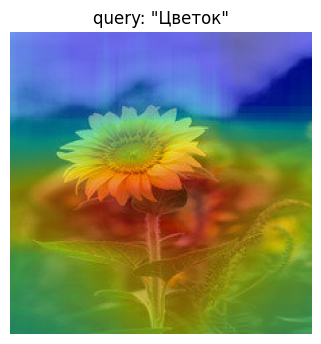

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, args = load_weights_only("ViT-B/32-small")
model = model.to(device).float().eval()
tokenizer = get_tokenizer()
clear_output(True)

try:
  image = Image.open(requests.get(picture_url, stream=True).raw)
except ValueError:
  image = Image.open(picture_url)

dim_y, dim_x = image.size
input_ids, attention_mask = get_text_batch([text], tokenizer, args)
input_ids = input_ids.to(device)
img_input = get_image_batch([image], args.img_transform, args).to(device)
v2 = model.visual_encoder(img_input)
v1 = model.text_encoder(input_ids)
cosine = torch.cosine_similarity(v1,v2).item()
initial_cos = cosine
saliency = np.zeros((dim_x, dim_y))

for _ in tqdm(range(n_iters)):
    im_tensor = np.array(image)
    x = random.randint(0,dim_x)
    y = random.randint(0,dim_y)
    w = random.randint(window,dim_x)
    h = random.randint(window,dim_y)
    h = (w + h) // 2
    im_tensor = im_tensor[max(x - w // 2,0) : min(x + w // 2, dim_x), max(y - h // 2,0) : min(y + h // 2, dim_y),...]
    
    img_input = get_image_batch([Image.fromarray(im_tensor)], args.img_transform, args).to(device)
    v1 = model.text_encoder(input_ids)
    v2 = model.visual_encoder(img_input)
    
    cosine = torch.cosine_similarity(v1,v2).item()
    saliency[max(x - w // 2,0) : min(x + w // 2, dim_x), max(y - h // 2,0) : min(y + h // 2, dim_y),...] += (cosine - initial_cos) / (im_tensor.shape[0] * im_tensor.shape[1])

im_tensor = np.array(image)
plt.figure(dpi=100)
plt.imshow(im_tensor)
plt.imshow(saliency, cmap='jet', alpha=0.5)
plt.title(f'query: \"{text}\"')
plt.axis("off")
plt.show()